[View in Colaboratory](https://colab.research.google.com/github/i-Hun/Cook_with_NN/blob/master/cook_with_nn.ipynb)

In [0]:
!pip install -U -q PyDrive

In [4]:
!pip install torch torchvision scikit-image imageio tqdm

In [0]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision import transforms, utils
import glob
import matplotlib.pyplot as plt
import json
from tqdm import tqdm_notebook
import cv2
import os
import pandas as pd
from skimage import io, transform
import numpy as np
from sklearn.preprocessing import OneHotEncoder
%matplotlib inline
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
imgs_file_id = '1sGtUUgSV4oMh8FxTqy1lQCAXUoCLDQPJ'
labels_file_id = "16Z1fjm9FTSplC2eqQB0ofvIScO0lfja_"
imgs_file = drive.CreateFile({'id': imgs_file_id})
labels_file = drive.CreateFile({'id': labels_file_id})
# print('Downloaded content "{}"'.format(downloaded.GetContentString()))

In [0]:
imgs_file.GetContentFile('imgs.zip')

In [0]:
labels_file.GetContentFile('data/recipes_by_id.json')

In [0]:
import zipfile
with zipfile.ZipFile("imgs.zip", "r") as zip_ref:
  if not os.path.exists('data'):
    os.makedirs('data')
  zip_ref.extractall("data/")

In [10]:
ls data

imgs/  __MACOSX/  recipes_by_id.json


In [0]:
IMG_DIR = "data/imgs/"

In [0]:
labels = json.load(open("data/recipes_by_id.json"))

In [15]:
labels_df = pd.DataFrame.from_dict(labels, orient="index").reset_index().drop("index", axis=1)
labels_df.head()

,title,img_src,ingredients,booked,likes,dislikes,time_to_cook,portions,category,id,sup_category,recipe_url
0,Огурцы в остром маринаде,//img02.rl0.ru/eda/c285x285i/s2.eda.ru/Photos/...,"[{'id': 13955, 'name': 'Рисовый уксус', 'amoun...",2271,110,18,5 минут,6 порций,Соленья и консервация,0,Заготовки,/recepty/zakuski/ogurci-v-ostrom-marinade-16230
1,Соус «Jack Daniel’s» по рецепту ресторана…,//img09.rl0.ru/eda/c285x285i/s1.eda.ru/Photos/...,"[{'id': 13430, 'name': 'Чеснок', 'amount': '1 ...",2287,106,6,2 часа,1 порция,Соленья и консервация,1,Заготовки,/recepty/sousy-marinady/sous-jack-daniel-s-po-...
2,Маринованный чеснок,//img05.rl0.ru/eda/c285x285i/s1.eda.ru/Photos/...,"[{'id': 13430, 'name': 'Чеснок', 'amount': '25...",347,8,0,20 минут,12 порций,Соленья и консервация,10,Заготовки,/recepty/zakuski/marinovannij-chesnok-29600
3,Скумбрия консервированная с яйцом и луком,None,"[{'id': 15485, 'name': 'Консервированная скумб...",8,1,0,10 минут,4 порции,Соленья и консервация,100,Заготовки,/recepty/zakuski/skumbrija-konservirovannaja-s...
4,Салат с куриным филе и стручковой фасолью,//img05.rl0.ru/eda/c285x285i/s1.eda.ru/Photos/...,"[{'id': 13544, 'name': 'Куриное филе', 'amount...",14,1,0,30 минут,4 порции,Салаты с курицей,1000,Салаты,/recepty/salaty/salat-s-kurinym-file-i-struchk...


In [0]:
labels_df.replace({"Бульоны": "Супы"}, inplace=True)

In [84]:
labels_df["sup_category"].value_counts()

Выпечка и десерты    5886
Основные блюда       2574
Закуски              2088
Супы                 1490
Напитки              1185
Салаты               1119
Завтраки              819
Соусы и маринады      344
Сэндвичи              253
Заготовки             177
Паста и пицца         159
Name: sup_category, dtype: int64

In [0]:
rev_prop = 1/labels_df["sup_category"].value_counts(normalize=True).values
rev_prop = rev_prop/rev_prop.sum()

In [0]:
labels_df.index = labels_df.index.astype(int)
labels_df.sort_index(inplace=True)

In [0]:
img_ids = [int(os.path.splitext(os.path.basename(name))[0])
           for name in glob.glob(IMG_DIR + "*")
           if os.path.splitext(os.path.basename(name))[0].isdigit()
          ]

In [0]:
labels_df = labels_df[labels_df["id"].isin(img_ids)]

In [44]:
labels_df.shape

(16094, 12)

In [45]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assume that we are on a CUDA machine, then this should print a CUDA device:

print(device)

cuda:0


In [0]:
BATCH_SIZE = 4

In [0]:
# https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

class RecipiesDataset(Dataset):

    def __init__(self, labels_df, img_dir, transform=None):
        """
        Args:
            labels_file (string): Path to the json with labels.
            img_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.img_dir = img_dir
        self.labels = labels_df
        self.supcat_dummies = pd.get_dummies(labels_df["sup_category"])
        self.supcat_names = self.supcat_dummies.columns
        self.transform = transform

    def __len__(self):
        img_ids = [os.path.splitext(os.path.basename(name))[0]
                   for name in glob.glob(self.img_dir + "*")
                   if os.path.splitext(os.path.basename(name))[0].isdigit()
                  ]
        return len(img_ids)

    def __getitem__(self, idx):
        _id = self.labels.iloc[int(idx)]["id"]
        
        img_path = os.path.join(self.img_dir, str(_id))
        if os.path.isfile(img_path + ".jpg"):
            img_name = img_path + ".jpg"
        elif os.path.isfile(img_path + ".png"):
            img_name = img_path + ".png"
        else:
            img_name = None
            raise Exception("Image with index {} does not exist".format(_id))
        if img_name:
            image = cv2.imread(img_name)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
                
            sample = {
                'image': image,
                'supcategory_labels': self.supcat_dummies.iloc[int(idx)].values
            }

            if self.transform:
                sample = self.transform(sample)

            return sample

In [0]:
recipies_dataset = RecipiesDataset(labels_df=labels_df,
                                    img_dir=IMG_DIR)

In [49]:
len(recipies_dataset.supcat_names)

11

In [0]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, labels = sample['image'], sample['supcategory_labels']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (self.output_size, self.output_size)) # кривое решение наличия неквадратных картинок

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        try:
            if img.shape[2] == 4:
                img = img[:,:,:-1]
        except Exception as err:
            print(err, img.shape, img)

        return {'image': img, 'supcategory_labels': labels}

In [0]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['supcategory_labels']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'supcategory_labels': torch.from_numpy(landmarks)}

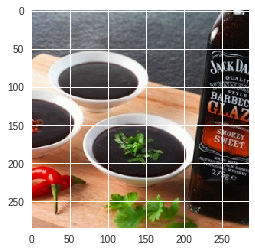

In [183]:
import cv2

img = cv2.imread(IMG_DIR + "1.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

In [0]:
transformed_dataset = RecipiesDataset(labels_df=labels_df,
                                    img_dir=IMG_DIR,
                                    transform=transforms.Compose([
                                        Rescale(256),
                                        ToTensor()
                                    ]))

In [185]:
len(transformed_dataset)

16094

In [0]:
weights = [torch.argmax(d["supcategory_labels"]) for d in transformed_dataset]

In [0]:
ww = [int(w.numpy()) for w in weights]

In [164]:
pd.Series(ww).value_counts(normalize=0, sort=False).sort_index()

0     5886
1      819
2      177
3     2088
4     1185
5     2574
6      159
7     1119
8      344
9     1490
10     253
dtype: int64

In [0]:
rev_prop = 1/pd.Series(ww).value_counts(normalize=0, sort=False).sort_index().values

In [0]:
sampler = torch.utils.data.sampler.WeightedRandomSampler(rev_prop[weights], len(transformed_dataset))

In [0]:
dataloader = DataLoader(transformed_dataset, batch_size=BATCH_SIZE, sampler=sampler)

In [168]:
supcat_labels = []
for num, data in enumerate(dataloader, 0):
  print(num, end='\r')
  supcat_labels.append(data["supcategory_labels"].cpu().numpy())

In [0]:
supcat_labels_2 = []

for i in supcat_labels:
  for j in i:
    supcat_labels_2.append(np.argmax(j))

In [170]:
from collections import Counter
Counter(supcat_labels_2).most_common()

[(9, 1534),
 (5, 1501),
 (1, 1489),
 (6, 1486),
 (2, 1462),
 (3, 1461),
 (10, 1460),
 (0, 1432),
 (8, 1429),
 (7, 1428),
 (4, 1412)]

In [0]:
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable



1.   256×256×3 — исходный размер.
2.   252×252×6 — после свёртки 
3.   126×126×6 — после макспуллинга
4.   122×122×16 — после свёртки
5.    61×61×16 — после макспуллинга
6.    Затем полносвязные слои



In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=3, # ширина, высота и цвет
            out_channels=6,
            kernel_size=5 # свёртка 5*5, т.е. по -4 пикселя по высоте и ширине (-2 верх, -2 низ, ...)
            # stride=1, padding=0
        )
        self.pool = nn.MaxPool2d( # ширина и высота уменьшаются в 2 раза
            kernel_size=2,
            stride=2
        )
        self.conv2 = nn.Conv2d(
            in_channels=6,
            out_channels=16,
            kernel_size=5
        )

        self.fc1 = nn.Linear(
            in_features=16 * 61 * 61,
            out_features=256
        )
        self.fc2 = nn.Linear(
            in_features=256,
            out_features=64
        )
        self.fc3 = nn.Linear(
            in_features=64,
            out_features=11
        )

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 61 * 61)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net().to(device)

In [193]:
import torch.optim as optim
import copy

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

for epoch in range(3):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(dataloader, 0):
        # get the inputs
        inputs, labels = \
          data["image"].type(torch.float32).to(device),\
          data["supcategory_labels"].type(torch.long).to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
#         print(inputs.shape)
        outputs = net(inputs).to(device)
        loss = criterion(outputs, torch.max(labels, 1)[1])
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.395
[1,  4000] loss: 2.369
[2,  2000] loss: 2.271
[2,  4000] loss: 1.792
[3,  2000] loss: 1.252
[3,  4000] loss: 0.984
Finished Training


In [0]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

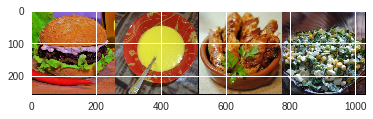

In [194]:
dataiter = next(iter(dataloader))
images, labels = dataiter["image"], dataiter["supcategory_labels"]

# print images
imshow(torchvision.utils.make_grid(images))

In [195]:
for i in torch.max(labels, 1)[1]:
    print(recipies_dataset.supcat_names[int(i)])

Сэндвичи
Соусы и маринады
Закуски
Салаты


In [0]:
outputs = net(images.type(torch.float32).to(device))

In [199]:
for i in torch.max(outputs, 1)[1]:
    print(recipies_dataset.supcat_names[int(i)])

Сэндвичи
Соусы и маринады
Закуски
Салаты


In [0]:
from torchvision import datasets, models, transforms

In [0]:
a = labels_df["ingredients"].apply(lambda l: [i["name"] for i in l]).values

In [215]:
np.concatenate(a).ravel().shape

(139259,)

In [0]:
from sklearn import preprocessing as pr

In [0]:
le = pr.LabelEncoder()

In [217]:
le.fit(np.concatenate(a).ravel())

LabelEncoder()

In [218]:
le.classes_

array([' 3,5%-ный йогурт', ' Готовые сухие листы лазаньи',
       ' Замороженная цветная мини капуста', ..., 'Ячневая крупа',
       'замороженное пюре из черной смородины ',
       'консервированная печень трески '], dtype='<U59')